<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [204]:
# imports

import pandas as pd
import spacy
import gensim
import re
import pyLDAvis.gensim

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [6]:
%pwd

'/home/tmbern/workspace/repos/lambda/DS-Unit-4-Sprint-1-NLP/module4-topic-modeling'

In [9]:
# read in dataset

df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
print(df.shape)
df.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [17]:
# how many primaryCategories are there?
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [35]:
# how many unique products (name feature) are there for each unique categories

df[(df['primaryCategories'] == 'Electronics') & ]['name'].value_counts()

Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                               2443
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                           2370
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                          1425
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                         1212
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                                           1024
Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers                                                                             987
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers               

In [65]:
# the vast majority of these individual product reviews relate to Fire Tablet.
# Lets filter it down where we are just looking at those products names that contain fire, tablets, and dont contain
# words like charger or adapters. This should give us all rievews for the fire tablets. 

# set up conditions that we want to filter based on
# if the name contains Fire or fire
fire_ = df['name'].str.contains('fire|Fire')

# if the name contains Tablet or tablet
tablet_ = df['name'].str.contains('Tablet|tablet')

# if the name doesnt contain charger or adapter
accessory_ = ~df['name'].str.contains('Charger|charger|Adapter|adapter')

# apply the conditions to filter the dataframe
fire_tablets = df[fire_ & tablet_ & accessory_]

print(fire_tablets.shape)
fire_tablets.head()


(14396, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
13386,AVqVGWQDv8e3D1O-ldFr,2017-03-03T16:55:53Z,2019-03-09T07:13:43Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","B018SZT3BK,B01AHB9CN2",Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Electronics,http://i.ebayimg.com/thumbs/images/g/9DAAAOSwE...,amazonfirehd88intablet16gbblackb018szt3bk6thge...,...,NaN,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,While there are some apps that are missing due...,. Nice hand sized tablet,greg,http://reviews.bestbuy.com/3545/5620406/review...
13387,AVpfw2hvilAPnD_xh0rH,2017-01-11T06:58:33Z,2019-03-09T07:13:43Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",B018Y226XO,Amazon,"Fire Tablets,Learning Toys,Toys,Tablets,Amazon...","Toys & Games,Electronics",https://pisces.bbystatic.com/image2/BestBuy_US...,"amazon/53004754,841667103372,0841667103372,7in...",...,NaN,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5026100/review...,great tablet for kids when traveling. my grand...,2 year old loves it,betty,http://www.toysrus.com/product/index.jsp?produ...
13388,AVqVGWQDv8e3D1O-ldFr,2017-03-03T16:55:53Z,2019-03-09T07:13:43Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","B018SZT3BK,B01AHB9CN2",Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Electronics,http://i.ebayimg.com/thumbs/images/g/9DAAAOSwE...,amazonfirehd88intablet16gbblackb018szt3bk6thge...,...,NaN,True,NaN,0.0,4,http://reviews.bestbuy.com/3545/5538501/review...,I bought one last year for one cousin and had ...,2nd purchase,VanStriker,http://reviews.bestbuy.com/3545/5620406/review...
13389,AVpfw2hvilAPnD_xh0rH,2017-01-11T06:58:33Z,2019-03-09T07:13:43Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",B018Y226XO,Amazon,"Fire Tablets,Learning Toys,Toys,Tablets,Amazon...","Toys & Games,Electronics",https://pisces.bbystatic.com/image2/BestBuy_US...,"amazon/53004754,841667103372,0841667103372,7in...",...,NaN,True,NaN,0.0,4,http://reviews.bestbuy.com/3545/5026100/review...,Bought this for my 2 yr old daughter. She was ...,2yr old approved,Mike,http://www.toysrus.com/product/index.jsp?produ...
13390,AVpfw2hvilAPnD_xh0rH,2017-01-11T06:58:33Z,2019-03-09T07:13:43Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",B018Y226XO,Amazon,"Fire Tablets,Learning Toys,Toys,Tablets,Amazon...","Toys & Games,Electronics",https://pisces.bbystatic.com/image2/BestBuy_US...,"amazon/53004754,841667103372,0841667103372,7in...",...,NaN,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5026100/review...,Kindle products are fantastic. I've used a kin...,3 year old granddaughter loves it!!! Easy for her,Jeanie,http://www.toysrus.com/product/index.jsp?produ...


## Clean text and Tokenize the reviews

In [71]:
# the text actually looks pretty clean so we wont do anything unless something jumps out to us later on
pd.set_option('display.max_colwidth', -1)
fire_tablets['reviews.text']

/home/tmbern/workspace/res/miniconda3/envs/Unit4-Sprint1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


13386    While there are some apps that are missing due to not using the Google Play Store the list is minimal. The tablet itself is quick, responsive, and noticeable nicer than the 7" fire. Picked this up when it was on sale for black friday sales. It's great for in front of the TV and catching up on email and light web browsing.
13387    great tablet for kids when traveling. my grandchild loves it.                                                                                                                                                                                                                                                                      
13388    I bought one last year for one cousin and had to continue for another this year. Great buy imo.                                                                                                                                                                                                                                    
1

In [195]:
# create a word counter function to make a dataframe of our total word counts
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [73]:

# import spacy this is done above


nlp = spacy.load("en_core_web_lg")


In [76]:
# create the tokens as lemmas
tokens = []

for doc in nlp.pipe(fire_tablets['reviews.text']):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop != True) and (token.pos_ != 'PRON')) and (token.is_punct !=True) and (token.is_space !=True) and (token.whitespace_ !=True):
            doc_tokens.append(token.lemma_.strip().lower())
            
    tokens.append(doc_tokens)

In [79]:
# verify that the length of the tokens is equal to the number of rows in the data frame. 
fire_tablets.shape[0] == len(tokens)

True

In [85]:
# what does one of the tokens look like?

tokens[6]

['try', '3rd', 'time', 'new', 'amazon', 'fire', 'nice', 'upgrade']

In [198]:
word_counts = count(tokens)
word_counts.head(25)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
6,tablet,5542,7308,1.0,0.038631,0.038631,0.384968
25,love,4536,5130,2.0,0.027118,0.065749,0.315088
0,great,4220,4975,3.0,0.026298,0.092047,0.293137
32,buy,3113,3575,4.0,0.018898,0.110945,0.216241
34,use,3085,3478,5.0,0.018385,0.129330,0.214296
67,good,2668,3134,6.0,0.016567,0.145897,0.185329
180,easy,2431,2657,7.0,0.014045,0.159942,0.168866
28,kid,2099,2609,8.0,0.013791,0.173733,0.145804
42,old,2091,2320,9.0,0.012264,0.185997,0.145249
17,app,1723,2208,10.0,0.011672,0.197669,0.119686


In [200]:
# the word tablet appears the most, but that is obvious because we are only looking at fire tablet reviews. Also Kindle is frequent.
# also, amazon should be removed because we are only looking at amazon reviews. Need to 

STOP_WORDS = nlp.Defaults.stop_words.union(['tablet', 'amazon', 'kindle'])

In [201]:
# create the tokens as lemmas with the new stop words.
tokens = []

for doc in nlp.pipe(fire_tablets['reviews.text']):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.text.lower() not in STOP_WORDS) and (token.pos_ != 'PRON')) and (token.is_punct !=True) and (token.is_space !=True) and (token.whitespace_ !=True):
            doc_tokens.append(token.lemma_.strip().lower())
            
    tokens.append(doc_tokens)

In [202]:
word_counts = count(tokens)
word_counts.head(25)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
24,love,4536,5130,1.0,0.028744,0.028744,0.315088
0,great,4220,4975,2.0,0.027876,0.056620,0.293137
31,buy,3113,3575,3.0,0.020031,0.076652,0.216241
33,use,3085,3478,4.0,0.019488,0.096140,0.214296
65,good,2668,3134,5.0,0.017560,0.113700,0.185329
177,easy,2431,2657,6.0,0.014888,0.128588,0.168866
27,kid,2099,2609,7.0,0.014619,0.143207,0.145804
41,old,2091,2320,8.0,0.012999,0.156206,0.145249
16,app,1723,2208,9.0,0.012372,0.168578,0.119686
2,fire,1818,2137,10.0,0.011974,0.180552,0.126285


## Gensim LDA Topic Modeling

In [88]:
# # this is imported above
# import gensim

# from gensim import corpora
# from gensim.models.ldamulticore import LdaMulticore

In [205]:
id2word = corpora.Dictionary(tokens) #A list of list of tokens 

In [206]:
len(id2word.keys())

5126

In [207]:
# we can filter out the extremes

id2word.filter_extremes(no_below=5, no_above=.95)

In [208]:
# this cut the values significantly
len(id2word.keys())

2016

In [209]:
# create the copora

corpus = [id2word.doc2bow(doc) for doc in tokens]

In [210]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1)]

In [211]:
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=7, 
                  passes=50)

In [212]:
# print the different topics
lda.print_topics()

[(0,
  '0.063*"use" + 0.062*"easy" + 0.036*"book" + 0.028*"great" + 0.026*"read" + 0.023*"love" + 0.019*"need" + 0.016*"app" + 0.014*"movie" + 0.014*"kid"'),
 (1,
  '0.055*"kid" + 0.026*"year" + 0.024*"case" + 0.024*"child" + 0.020*"old" + 0.019*"great" + 0.018*"time" + 0.018*"love" + 0.017*"buy" + 0.016*"come"'),
 (2,
  '0.067*"buy" + 0.052*"love" + 0.035*"gift" + 0.027*"purchase" + 0.025*"christmas" + 0.022*"great" + 0.022*"use" + 0.019*"product" + 0.016*"work" + 0.016*"good"'),
 (3,
  '0.053*"app" + 0.018*"store" + 0.018*"like" + 0.018*"play" + 0.017*"google" + 0.015*"device" + 0.014*"work" + 0.012*"screen" + 0.011*"use" + 0.010*"android"'),
 (4,
  '0.039*"fire" + 0.027*"great" + 0.021*"ipad" + 0.020*"buy" + 0.020*"good" + 0.019*"price" + 0.018*"hd" + 0.017*"8" + 0.014*"want" + 0.014*"$"'),
 (5,
  '0.081*"great" + 0.059*"price" + 0.057*"good" + 0.027*"screen" + 0.024*"product" + 0.020*"size" + 0.020*"battery" + 0.019*"easy" + 0.019*"nice" + 0.017*"love"'),
 (6,
  '0.087*"love" + 0.0

In [213]:
# # imported above
# import re
words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]

In [214]:
topics = [' '.join(t[0:7]) for t in words]

In [215]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
use easy book great read love need

------ Topic 1 ------
kid year case child old great time

------ Topic 2 ------
buy love gift purchase christmas great use

------ Topic 3 ------
app store like play google device work

------ Topic 4 ------
fire great ipad buy good price hd

------ Topic 5 ------
great price good screen product size battery

------ Topic 6 ------
love old game year play buy daughter



## Interpret LDA Results

In [216]:
# # imported above
# import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [217]:
pyLDAvis.gensim.prepare(lda,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.226591  0.023664       1        1  15.805427
4      0.157032 -0.011893       2        1  15.341293
3      0.049498  0.158632       3        1  15.220371
1     -0.102158 -0.045307       4        1  13.786289
2     -0.075542 -0.177833       5        1  13.607634
5      0.191836 -0.102183       6        1  13.390075
0      0.005925  0.154920       7        1  12.848907, topic_info=         Term         Freq        Total Category  logprob  loglift
39        old  2274.000000  2274.000000  Default  30.0000  30.0000
190     price  1965.000000  1965.000000  Default  29.0000  29.0000
26       love  5024.000000  5024.000000  Default  28.0000  28.0000
31       year  1929.000000  1929.000000  Default  27.0000  27.0000
1         app  2208.000000  2208.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
53       like   164.076736  1560.443604   Topic7  -4.9017  -0.2005
115    device   151.176804   787.187805   Topic7  -4.9836   0.4019
312      want   152.131516   966.088501   Topic7  -4.9773   0.2034
59   purchase   153.202988  1621.675171   Topic7  -4.9703  -0.3075
28        buy   154.855865  3505.994629   Topic7  -4.9596  -1.0678

[549 rows x 6 columns], token_table=      Topic      Freq Term
term                      
193       2  0.981357    $
193       3  0.007914    $
193       4  0.002638    $
193       6  0.007914    $
1343      1  0.850743  1/2
...     ...       ...  ...
42        1  0.886225   yr
42        4  0.102945   yr
42        7  0.004476   yr
96        4  0.942208  yrs
1860      4  0.893753    ©

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 4, 2, 3, 6, 1])

In [218]:
lda[corpus[5]]

[(1, 0.29557794), (3, 0.18642935), (6, 0.50205415)]

In [219]:
# a list of lists of different corpora
distro = [lda[d] for d in corpus]

In [220]:
def update(doc):
        d_dist = {k:0 for k in range(0,7)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [221]:
new_distro

[{0: 0, 1: 0, 2: 0, 3: 0.326943, 4: 0.529087, 5: 0.12194161, 6: 0},
 {0: 0.32528663,
  1: 0.023928761,
  2: 0.023872044,
  3: 0.02383104,
  4: 0.023845647,
  5: 0.02391997,
  6: 0.5553159},
 {0: 0.017879238,
  1: 0.017917287,
  2: 0.56679815,
  3: 0.017878547,
  4: 0.017888159,
  5: 0.017908314,
  6: 0.34373036},
 {0: 0, 1: 0, 2: 0.12590499, 3: 0, 4: 0, 5: 0, 6: 0.8343115},
 {0: 0.017915413,
  1: 0.017891308,
  2: 0.8925662,
  3: 0.017893786,
  4: 0.01793398,
  5: 0.0178932,
  6: 0.017906122},
 {0: 0, 1: 0.29557586, 2: 0, 3: 0.18643023, 4: 0, 5: 0, 6: 0.5020554},
 {0: 0.017880064,
  1: 0.6118632,
  2: 0.017910512,
  3: 0.017907871,
  4: 0.29859814,
  5: 0.017959572,
  6: 0.017880669},
 {0: 0.59864116, 1: 0, 2: 0.35354528, 3: 0, 4: 0, 5: 0, 6: 0},
 {0: 0,
  1: 0.14531545,
  2: 0,
  3: 0.27462605,
  4: 0,
  5: 0.08583966,
  6: 0.48076653},
 {0: 0.04762592,
  1: 0.04776762,
  2: 0.4078791,
  3: 0.35343206,
  4: 0.047696568,
  5: 0.047726966,
  6: 0.047871795},
 {0: 0.0129999705,
  1: 0.01

In [222]:
doc_topics = pd.DataFrame.from_records(new_distro)
doc_topics.columns = topics

In [223]:
doc_topics.head()

,use easy book great read love need,kid year case child old great time,buy love gift purchase christmas great use,app store like play google device work,fire great ipad buy good price hd,great price good screen product size battery,love old game year play buy daughter
0,0.000000,0.000000,0.000000,0.326943,0.529087,0.121942,0.000000
1,0.325287,0.023929,0.023872,0.023831,0.023846,0.023920,0.555316
2,0.017879,0.017917,0.566798,0.017879,0.017888,0.017908,0.343730
3,0.000000,0.000000,0.125905,0.000000,0.000000,0.000000,0.834311
4,0.017915,0.017891,0.892566,0.017894,0.017934,0.017893,0.017906


In [224]:
doc_topics.idxmax(axis=1)

0                   fire great ipad buy good price hd
1                love old game year play buy daughter
2          buy love gift purchase christmas great use
3                love old game year play buy daughter
4          buy love gift purchase christmas great use
                             ...                     
14391            love old game year play buy daughter
14392            love old game year play buy daughter
14393              use easy book great read love need
14394               fire great ipad buy good price hd
14395    great price good screen product size battery
Length: 14396, dtype: object

## select topics

In [225]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [227]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=10)

In [228]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

topic_coherence.head(10)

,pass,num_topics,coherence_score
0,0,3,-2.062693
1,0,5,-2.202463
2,0,7,-2.211156
3,0,9,-2.235375
4,0,11,-2.275118
5,0,13,-2.255614
6,0,15,-2.246437
7,0,17,-2.237228
8,0,19,-2.260210
9,0,21,-2.225580


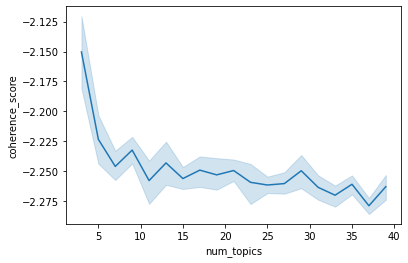

In [229]:
import seaborn as sns
 
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Make visualizations

In [230]:
fire_tablets = fire_tablets.copy()

fire_tablets['topic'] = doc_topics.idxmax(axis=1)

In [231]:
pd.reset_option('display.max_colwidth')
fire_tablets.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,topic
13386,AVqVGWQDv8e3D1O-ldFr,2017-03-03T16:55:53Z,2019-03-09T07:13:43Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","B018SZT3BK,B01AHB9CN2",Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Electronics,http://i.ebayimg.com/thumbs/images/g/9DAAAOSwE...,amazonfirehd88intablet16gbblackb018szt3bk6thge...,...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,While there are some apps that are missing due...,. Nice hand sized tablet,greg,http://reviews.bestbuy.com/3545/5620406/review...,use easy book great read love need
13387,AVpfw2hvilAPnD_xh0rH,2017-01-11T06:58:33Z,2019-03-09T07:13:43Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",B018Y226XO,Amazon,"Fire Tablets,Learning Toys,Toys,Tablets,Amazon...","Toys & Games,Electronics",https://pisces.bbystatic.com/image2/BestBuy_US...,"amazon/53004754,841667103372,0841667103372,7in...",...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5026100/review...,great tablet for kids when traveling. my grand...,2 year old loves it,betty,http://www.toysrus.com/product/index.jsp?produ...,love old game year play buy daughter
13388,AVqVGWQDv8e3D1O-ldFr,2017-03-03T16:55:53Z,2019-03-09T07:13:43Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","B018SZT3BK,B01AHB9CN2",Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Electronics,http://i.ebayimg.com/thumbs/images/g/9DAAAOSwE...,amazonfirehd88intablet16gbblackb018szt3bk6thge...,...,True,NaN,0.0,4,http://reviews.bestbuy.com/3545/5538501/review...,I bought one last year for one cousin and had ...,2nd purchase,VanStriker,http://reviews.bestbuy.com/3545/5620406/review...,love old game year play buy daughter


In [246]:
fire_tablets.groupby(['primaryCategories', 'topic']).mean().reset_index()

,primaryCategories,topic,reviews.id,reviews.numHelpful,reviews.rating
0,Electronics,app store like play google device work,NaN,0.055556,4.666667
1,Electronics,buy love gift purchase christmas great use,NaN,0.223301,4.495146
2,Electronics,fire great ipad buy good price hd,NaN,0.525180,4.496403
3,Electronics,great price good screen product size battery,NaN,0.283019,4.679245
4,Electronics,kid year case child old great time,NaN,0.294118,4.500000
5,Electronics,love old game year play buy daughter,NaN,0.055556,4.518519
6,Electronics,use easy book great read love need,NaN,0.226891,4.512605
7,"Toys & Games,Electronics",app store like play google device work,NaN,0.063830,4.468085
8,"Toys & Games,Electronics",buy love gift purchase christmas great use,NaN,0.203125,4.468750
9,"Toys & Games,Electronics",fire great ipad buy good price hd,NaN,0.192982,4.473684


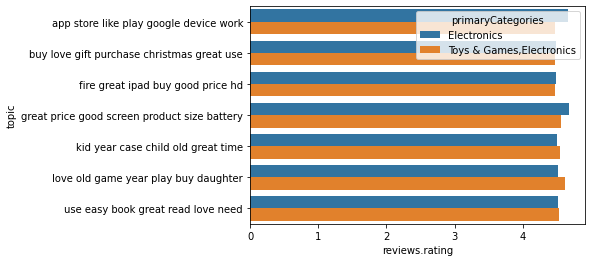

In [255]:
# this isnt a great visualization as all the means are so close. 
# just shows that people really love their fire tablets! regardless of what
# category the review was left in

import matplotlib.pyplot as plt
x = fire_tablets.groupby(['primaryCategories', 'topic']).mean().reset_index()['reviews.rating']
y = fire_tablets.groupby(['primaryCategories', 'topic']).mean().reset_index()['topic']
hue = fire_tablets.groupby(['primaryCategories', 'topic']).mean().reset_index()['primaryCategories']
plt.xticks(rotation=0)

sns.barplot(x=x, y=y, hue=hue)

In [270]:
length_review = []

for row in fire_tablets['reviews.text']:
    length_review.append(len(row))


In [271]:
fire_tablets['review.length'] = length_review

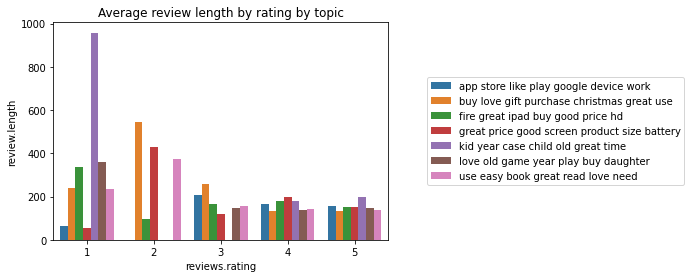

In [290]:
# what is the average length of a review by rating and topic?

y = fire_tablets.groupby(['topic', 'reviews.rating']).mean().reset_index()['review.length']
x = fire_tablets.groupby(['topic', 'reviews.rating']).mean().reset_index()['reviews.rating']
hue = fire_tablets.groupby(['topic', 'reviews.rating']).mean().reset_index()['topic']
plt.title('Average review length by rating by topic')


g = sns.barplot(x=x, y=y, hue=hue)

g.legend(loc='right', bbox_to_anchor=(1.9, 0.5), ncol=1)

In [277]:
fire_tablets.groupby(['topic', 'reviews.rating']).mean().reset_index()

,topic,reviews.rating,reviews.id,reviews.numHelpful,review.length
0,app store like play google device work,1,NaN,0.000000,63.000000
1,app store like play google device work,3,NaN,0.000000,206.500000
2,app store like play google device work,4,NaN,0.096774,167.322581
3,app store like play google device work,5,NaN,0.046154,158.215385
4,buy love gift purchase christmas great use,1,NaN,3.250000,240.000000
5,buy love gift purchase christmas great use,2,NaN,0.500000,546.500000
6,buy love gift purchase christmas great use,3,NaN,0.000000,259.636364
7,buy love gift purchase christmas great use,4,NaN,0.119048,131.738095
8,buy love gift purchase christmas great use,5,NaN,0.157407,133.638889
9,fire great ipad buy good price hd,1,NaN,0.400000,335.200000


Looking at the different topic it appears that most people that buy a fire tablet give the tablet a great rating, regardless of the topic that review falls under.

When looking at the average length of the ratings by topic, it looks like those that there is a good amount of variance in length of review by topic, when it comes to topics. But that is only apparent for ratings 3 or below. topics that have a rating of 4-5 tend to have the same average word count, regardless of the topic. That was interesting. 

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling